Loaded 120 synthetic experiments
Methods: ['lasso' 'nimo' 'random_forest']
Detected synthetic datasets: ['A', 'B', 'C', 'D', 'E']
Number of scenarios: 5

OVERFITTING ANALYSIS
LASSO       : F1 Gap=+0.020 (GOOD FIT    ), Acc Gap=+0.021 (GOOD FIT)
NIMO        : F1 Gap=+0.023 (GOOD FIT    ), Acc Gap=+0.025 (GOOD FIT)
RANDOM_FOREST: F1 Gap=+0.209 (OVERFITTING ), Acc Gap=+0.220 (OVERFITTING)


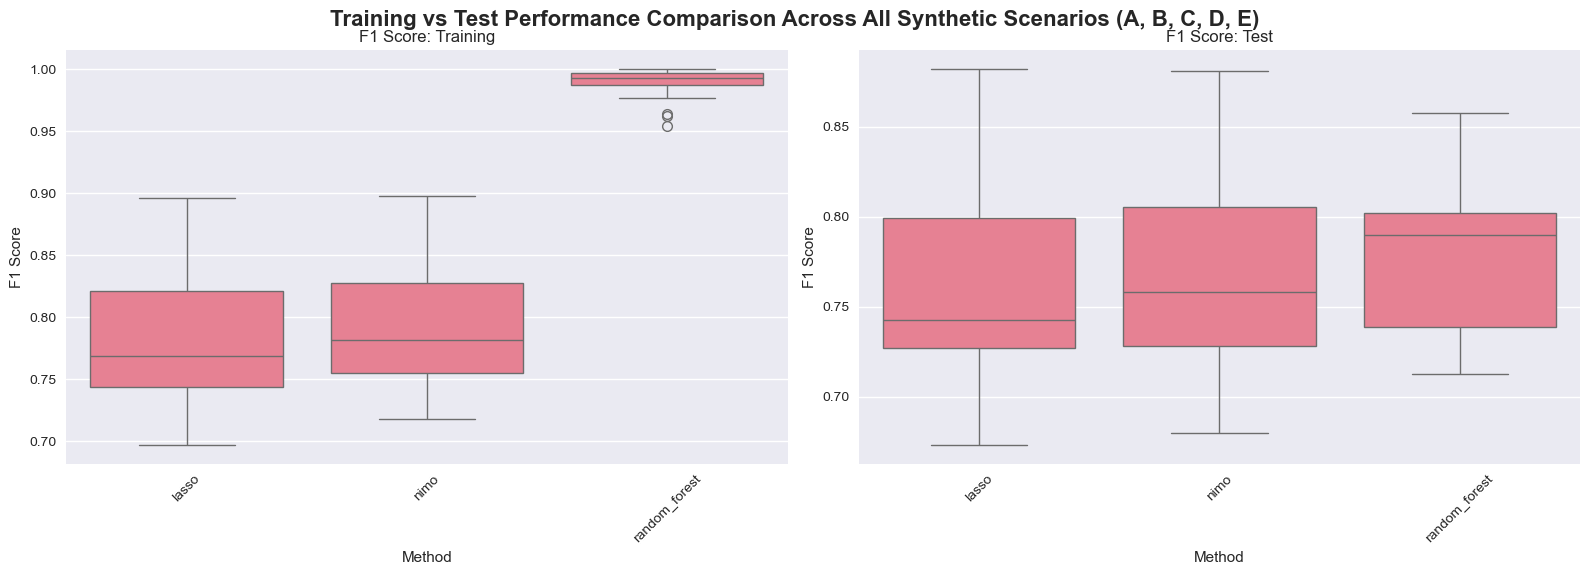

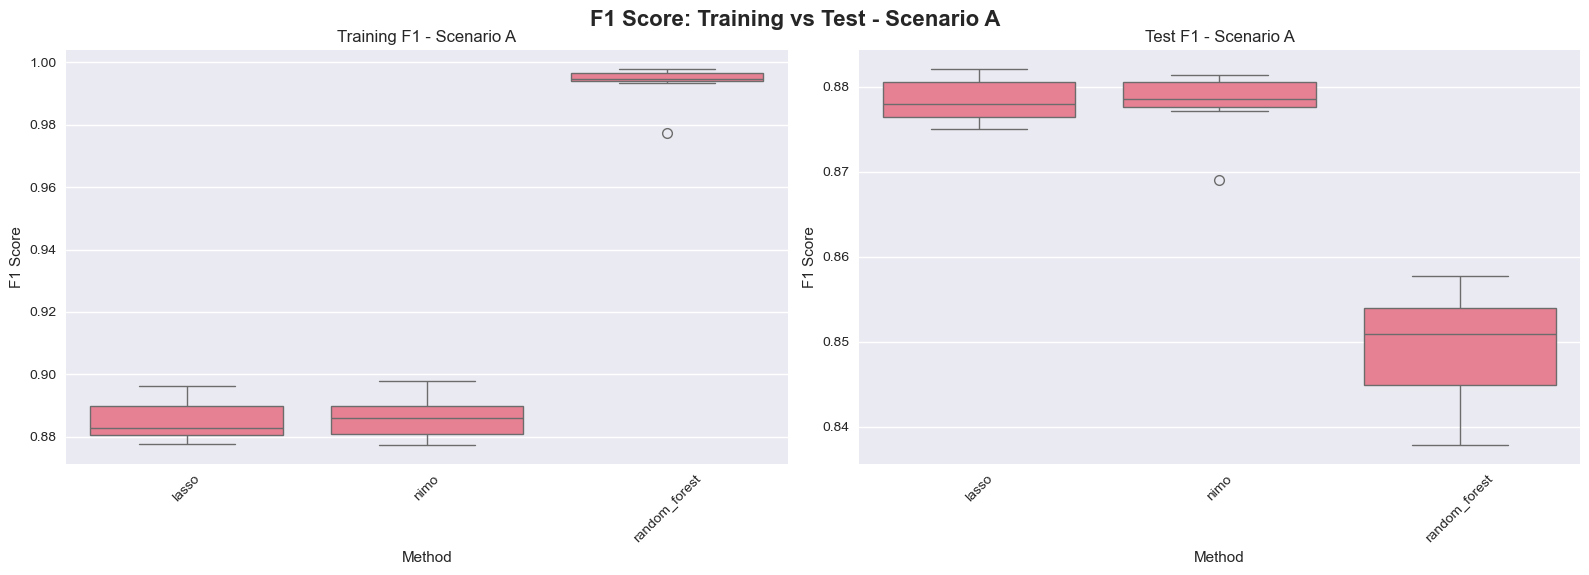

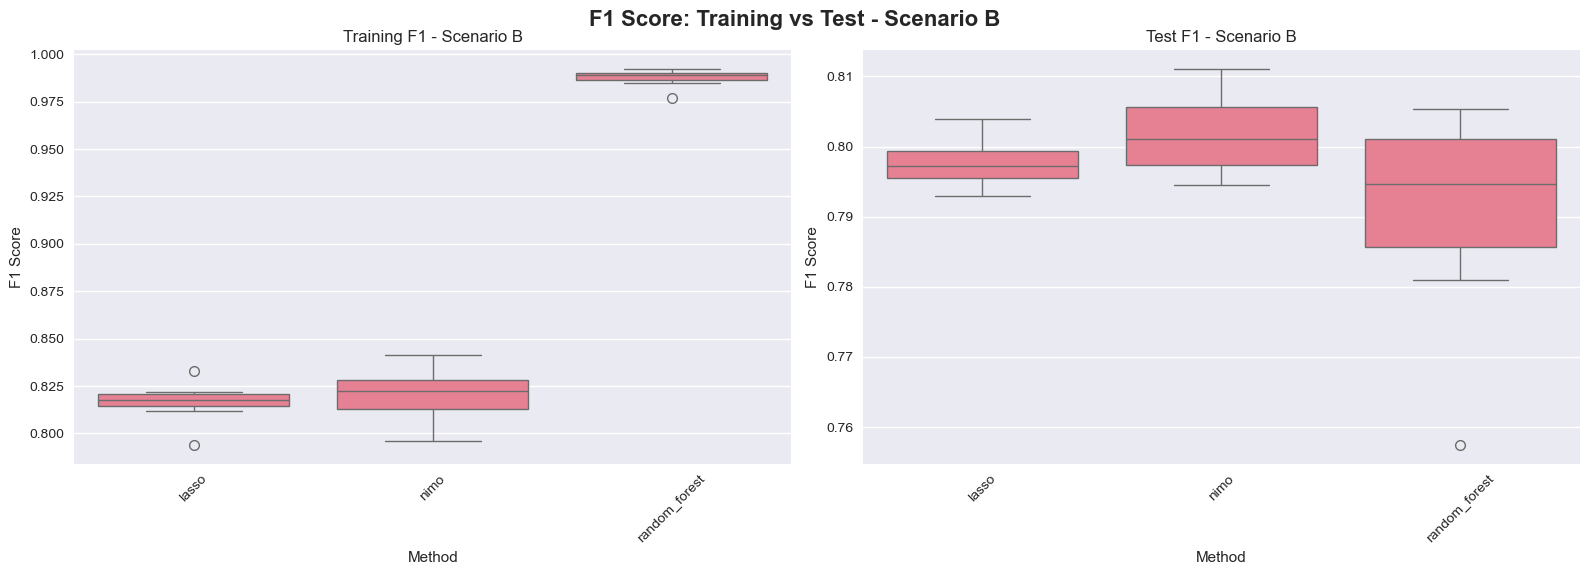

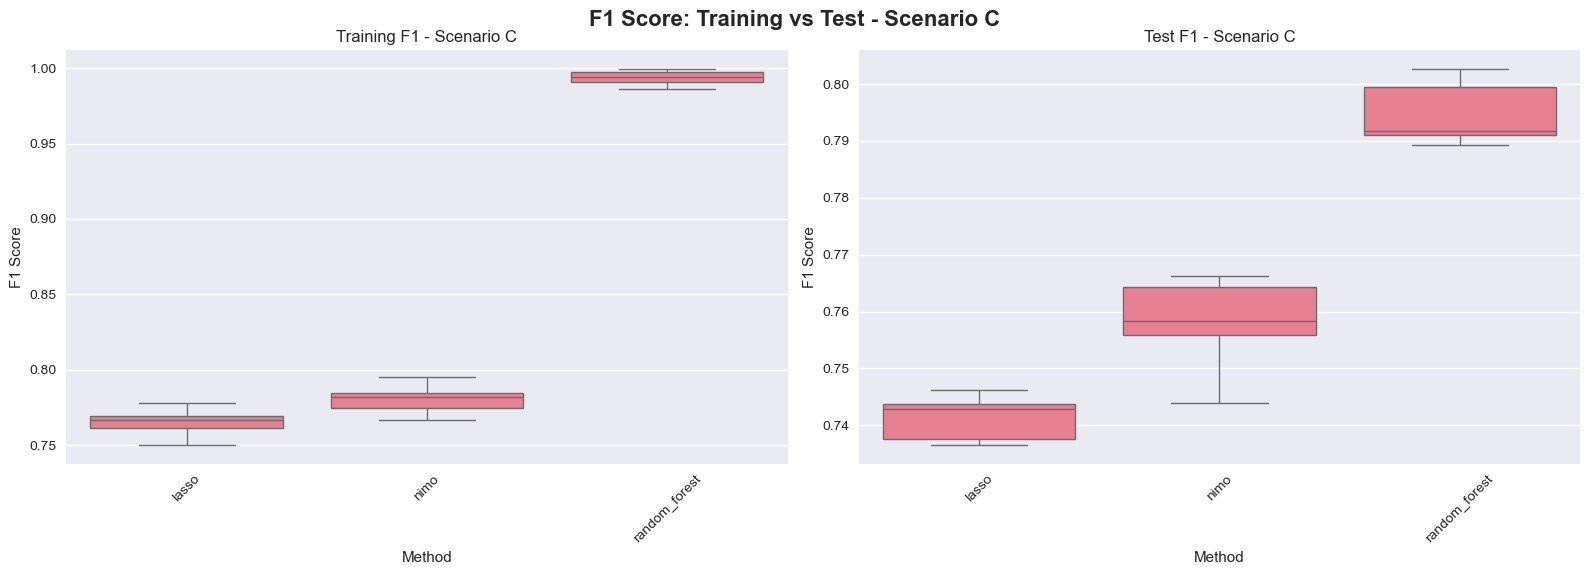

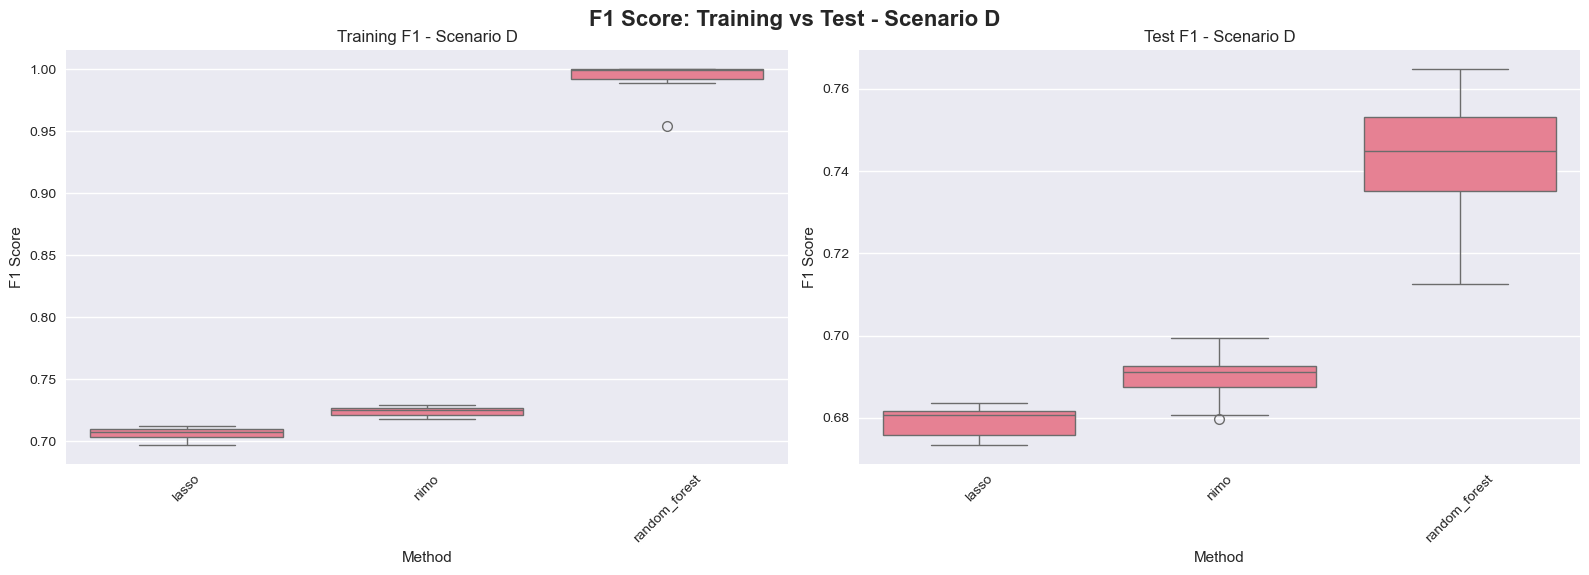

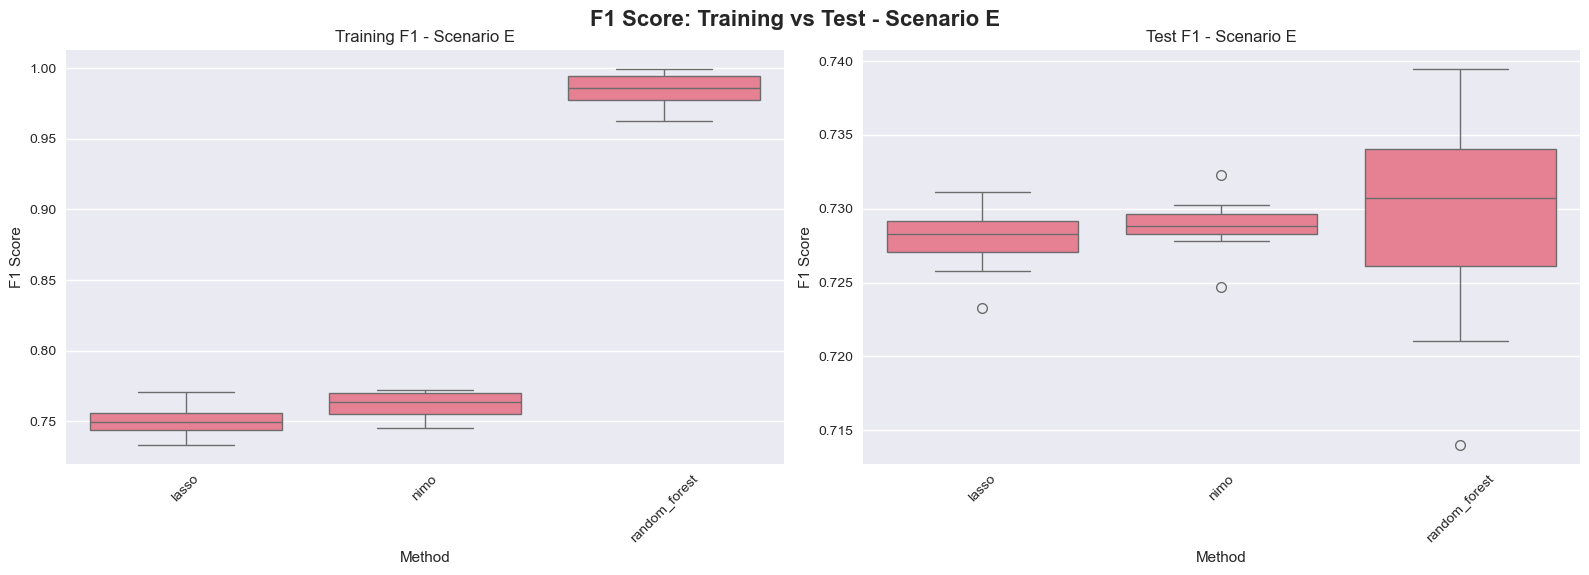

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load data
results_path = Path('../../../results/all/experiment_results.csv')
df = pd.read_csv(results_path)

# Dynamically detect all synthetic datasets (A, B, C, D, E, F, etc.)
# Synthetic datasets are typically single letters
synthetic_datasets = sorted([d for d in df['dataset_id'].unique() if len(d) == 1 and d.isalpha()])
df_synthetic = df[df['dataset_id'].isin(synthetic_datasets)]

print(f"Loaded {len(df_synthetic)} synthetic experiments")
print(f"Methods: {df_synthetic['model_name'].unique()}")
print(f"Detected synthetic datasets: {synthetic_datasets}")
print(f"Number of scenarios: {len(synthetic_datasets)}")



# 1. Training vs Test Performance Comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Add main title
fig.suptitle(f'Training vs Test Performance Comparison Across All Synthetic Scenarios ({", ".join(synthetic_datasets)})', 
             fontsize=16, fontweight='bold', y=0.95)

# Check if training metrics are available
has_train_f1 = 'train_f1' in df_synthetic.columns
has_train_accuracy = 'train_accuracy' in df_synthetic.columns

if has_train_f1 and has_train_accuracy:
    # F1 Score - Training (left plot)
    sns.boxplot(data=df_synthetic, x='model_name', y='train_f1', ax=axes[0])
    axes[0].set_title('F1 Score: Training')
    axes[0].set_xlabel('Method')
    axes[0].set_ylabel('F1 Score')
    axes[0].tick_params(axis='x', rotation=45)
    
    # F1 Score - Test (right plot)
    sns.boxplot(data=df_synthetic, x='model_name', y='f1', ax=axes[1])
    axes[1].set_title('F1 Score: Test')
    axes[1].set_xlabel('Method')
    axes[1].set_ylabel('F1 Score')
    axes[1].tick_params(axis='x', rotation=45)
    
    # Calculate overfitting gaps for analysis
    df_synthetic['overfitting_gap_f1'] = df_synthetic['train_f1'] - df_synthetic['f1']
    df_synthetic['overfitting_gap_acc'] = df_synthetic['train_accuracy'] - df_synthetic['accuracy']
    
    # Print overfitting analysis
    print("\n" + "="*80)
    print("OVERFITTING ANALYSIS")
    print("="*80)
    
    for method in df_synthetic['model_name'].unique():
        method_data = df_synthetic[df_synthetic['model_name'] == method]
        f1_gap = method_data['overfitting_gap_f1'].mean()
        acc_gap = method_data['overfitting_gap_acc'].mean()
        
        if f1_gap > 0.05:
            f1_status = "OVERFITTING"
        elif f1_gap < -0.05:
            f1_status = "UNDERFITTING"
        else:
            f1_status = "GOOD FIT"
            
        if acc_gap > 0.05:
            acc_status = "OVERFITTING"
        elif acc_gap < -0.05:
            acc_status = "UNDERFITTING"
        else:
            acc_status = "GOOD FIT"
        
        print(f"{method.upper():12}: F1 Gap={f1_gap:+.3f} ({f1_status:12}), Acc Gap={acc_gap:+.3f} ({acc_status})")

else:
    # Fallback to original plots if training metrics not available
    print("Training metrics not available. Showing test performance only.")
    
    # F1 Score
    sns.boxplot(data=df_synthetic, x='model_name', y='f1', ax=axes[0])
    axes[0].set_title('F1 Score Distribution by Method')
    axes[0].set_xlabel('Method')
    axes[0].set_ylabel('F1 Score')
    axes[0].tick_params(axis='x', rotation=45)
    
    # Accuracy
    sns.boxplot(data=df_synthetic, x='model_name', y='accuracy', ax=axes[1])
    axes[1].set_title('Accuracy Distribution by Method')
    axes[1].set_xlabel('Method')
    axes[1].set_ylabel('Accuracy')
    axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


# 4. F1 Score by Dataset - Training vs Test (side by side for each scenario)
if has_train_f1 and has_train_accuracy:
    # For each scenario, create 2 plots side by side (Training | Test)
    n_scenarios = len(synthetic_datasets)
    
    for i, dataset in enumerate(synthetic_datasets):
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Add main title for this scenario
        fig.suptitle(f'F1 Score: Training vs Test - Scenario {dataset}', 
                     fontsize=16, fontweight='bold', y=0.95)
        
        dataset_data = df_synthetic[df_synthetic['dataset_id'] == dataset]
        
        # Left plot: Training F1
        sns.boxplot(data=dataset_data, x='model_name', y='train_f1', ax=axes[0])
        axes[0].set_title(f'Training F1 - Scenario {dataset}')
        axes[0].set_xlabel('Method')
        axes[0].set_ylabel('F1 Score')
        axes[0].tick_params(axis='x', rotation=45)
        
        # Right plot: Test F1
        sns.boxplot(data=dataset_data, x='model_name', y='f1', ax=axes[1])
        axes[1].set_title(f'Test F1 - Scenario {dataset}')
        axes[1].set_xlabel('Method')
        axes[1].set_ylabel('F1 Score')
        axes[1].tick_params(axis='x', rotation=45)
        
        # Add overfitting gap as text on the test plot
        gap_f1 = dataset_data['overfitting_gap_f1'].mean()
        # axes[1].text(0.02, 0.98, f'Avg Overfitting Gap: {gap_f1:+.3f}',
        #             transform=axes[1].transAxes, fontsize=10,
        #             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
        #             verticalalignment='top')
        
        plt.tight_layout()
        plt.show()

else:
    # Fallback to original plots if training metrics not available
    print("Training metrics not available. Showing test performance by scenario only.")
    
    # Dynamic subplot layout based on number of scenarios
    n_scenarios = len(synthetic_datasets)
    n_cols = min(3, n_scenarios)  # Max 3 columns
    n_rows = (n_scenarios + n_cols - 1) // n_cols  # Ceiling division

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    if n_scenarios == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes if isinstance(axes, list) else [axes]
    else:
        axes = axes.flatten()

    # Add main title
    fig.suptitle(f'F1 Score Across All Synthetic Scenarios ({", ".join(synthetic_datasets)})', 
                 fontsize=16, fontweight='bold', y=0.95)

    for i, dataset in enumerate(synthetic_datasets):
        dataset_data = df_synthetic[df_synthetic['dataset_id'] == dataset]

        # F1 Score by method for this dataset
        sns.boxplot(data=dataset_data, x='model_name', y='f1', ax=axes[i])
        axes[i].set_title(f'F1 Score - Scenario {dataset}')
        axes[i].set_xlabel('Method')
        axes[i].set_ylabel('F1 Score')
        axes[i].tick_params(axis='x', rotation=45)

    # Hide unused subplots
    for i in range(n_scenarios, len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()
    plt.show()

